In [1]:
#| code-fold: true
#| code-summary: "Show pip installs and imports"
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#| code-fold: true
#| code-summary: "Show code to load models"
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

## Background

In this notebook, I rearrange the code provided in the fastai course Part 2 notebook 
[Stable Diffusion Deep Dive](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb) to 
create a GIF transitioning from a picture of a skunk to a picture of a puppy in a relatively visually smooth and stable manner.

I combine two concepts introduced in that notebook:

- The diffusion loop starting from a noised version of input (aka image2image)
- Replacing/mixing token embeddings to alter the generated image (for example a mixed skunk/puppy embeddings/image)

I'll reuse the helper functions provided in that notebook:

- `set_timesteps`: uses the scheduler algorithm to generate the timesteps and noise for a given number of inference steps.
- `pil_to_latent`: uses the VAE to encode a 512x512 pixel image into a 1x4x64x64 latent.
- `latents_to_pil`: uses the VAE to decode a 1x4x64x64 latent into a 512x512 PIL Image.
- `get_output_embeds`: uses (most of the) code from the `forward` pass of the `text_encoder.text_model` to encode token  + position embeddings.

In [3]:
#| code-fold: true
#| code-summary: "Show `set_timesteps`"
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

In [4]:
#| code-fold: true
#| code-summary: "Show `pil_to_latent` and `latents_to_pil`"
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [5]:
#| code-fold: true
#| code-summary: "Show `get_output_embeds`"
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

I also prepare the `token_embedding` layer and `position_embedding` layer as done in the notebook:

In [6]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding

In [7]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)

torch.Size([1, 77, 768])


## Mixing and Replacing Text Embeddings

I start by taking a prompt, `A picture of a puppy`, tokenizing it, and creating its embeddings:

In [8]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

Next, I want to replace the token embeddings for `puppy` with an averaged embedding of `skunk` and `puppy`. I start (as the course notebook does) 
by first generating embeddings for the `puppy` (`6829`) and `skunk` (`42194`) tokens:

In [9]:
# The new embedding. Which is now a mixture of the token embeddings for 'puppy' and 'skunk'
puppy_token_embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
skunk_token_embedding = token_emb_layer(torch.tensor(42194, device=torch_device))

I then choose a weighting factor (I'll start with 50% `puppy` and 50% `skunk`) to mix the two token embeddings:

In [10]:
puppy_factor = 0.5
replacement_token_embedding = puppy_factor*puppy_token_embedding + (1-puppy_factor)*skunk_token_embedding

Now for the replacement operation: using `where`, we swap out the 100% `puppy` token embeddings with the mixed `puppy/skunk` embeddings:

In [11]:
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

We then combine the full set of token embeddings with position embeddings and pass it through the `forward` pass of the text encoder:

In [12]:
# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

## Generating a Mixed Puppy/Skunk Image

With the text embeddings in hand, we can now generate a puppy/skunk hybrid image using the U-Net: first we set some constants (I'll use the 
same ones as the course notebook):

In [13]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

Next we create embeddings for an empty prompt (aka the _unconditioned_ input) and concatenate it to the puppy/skunk hybrid token embeddings:

In [14]:
max_length = modified_output_embeddings.shape[-2]

uncond_input = tokenizer(
  [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)

with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    
text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

We initialize the `scheduler` with the given number of inference steps:

In [15]:
# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

And initialize a random set of latents as the starting point for the image generation. Note that this one of the main things I'll change later on 
when I want to create a smooth GIF transition from 100% skunk to 100% puppy (where I'll start with a noisy image's latents instead of fully random 
noisy latents):

In [16]:
# Prep latents
latents = torch.randn(
(batch_size, unet.in_channels, height // 8, width // 8),
generator=generator,
)

latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

/tmp/ipykernel_2631/4273587132.py:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


Finally, we can run the diffusion loop, where we generate U-Net predictions for both conditioned and unconditioned (empty) text embeddings, using 
the `guidance_scale` to guide the diffusion process towards the conditioned text embeddings.

The result is a creature that looks like both a skunk and a puppy---a skunk/puppy hybrid!

  0%|          | 0/30 [00:00<?, ?it/s]

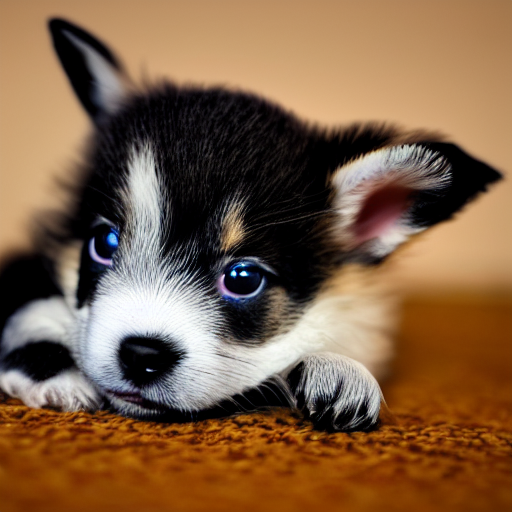

In [17]:
#| code-fold: true
#| code-summary: "Show diffusion loop"
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]

## Transitioning from 100% Skunk to 100% Puppy

I'll now modify the above process so that I can use the previous image as a starting point for the next image's generation. Why would I want to 
do that? Well, to illustrate why, I'll generate 11 images that each start out with random noisy latents. The first image will be generated with 
100% `skunk` and 0% `puppy` token embeddings, incrementing by 10% until the last image is 0% `skunk` and 100% `puppy` token embeddings. I'll then 
combine the images into a GIF and show how it has a choppy transition between frame since each image starts at a random spot in the latent space.

I'll use the `generate_with_embs` function from the course notebook which takes the code above and wraps it into a function:

In [18]:
#| code-fold: true
#| code-summary: "Show `generate_with_embs`"
def generate_with_embs(text_embeddings, seed):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

I'll iterate between a `puppy_factor` of `0` to `1.0`, generating new mixed token embeddings at each step and corresponding image.

In [ ]:
#| code-fold: true
#| code-summary: "Show `puppy_factor` loop"
imgs = []
seed = 4
n = 10
for i in range(n + 1):
  puppy_factor = i * 1. / n 

  # replace puppy embeddings with weighted average of puppy and skunk embeddings
  replacement_token_embedding = puppy_factor*puppy_token_embedding + (1-puppy_factor)*skunk_token_embedding

  # Insert this into the token embeddings (
  token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

  # Combine with pos embs
  input_embeddings = token_embeddings + position_embeddings

  #  Feed through to get final output embs
  modified_output_embeddings = get_output_embeds(input_embeddings)

  # Generate an image with these
  img = generate_with_embs(modified_output_embeddings, seed=seed)

  imgs.append(img)

I'll use this nifty one-liner provided by Claude to generate a GIF:

In [20]:
imgs[0].save(f'/notebooks/skunk-to-puppy_random_{seed}.gif', save_all=True, append_images=imgs[1:], duration=200, loop=0)

As you can see in the GIF below, the transition from image to the next, especially once it goes from mostly-skunk to mostly-puppy, is choppy.
Notice especially how the pose of the creature, as well as the background, significantly change from the start to 
finish of the animation.

![Skunk to Puppy animation where each subsequent image starts from a random noisy latent](skunk-to-puppy_random_4.gif)

## Making the Skunk-to-Puppy Transition Smoother

I'll now modify the generation loop by doing the following:

- On the first step of the `puppy_factor` loop, start with a random noisy latent.
- On all subsequent steps, start with a latent of the previous step's image with some "delayed" timestep noise added to it.

To accomplish this (and reuse as much course notebook code as possible), I'll modify `generate_with_embs`. First off, I'll walk through the updated 
parameters to this function:

- `text_embeddings`: same as before, these are the mixed text embeddings (with some ratio of skunk-to-puppy)
- `encoded`: this is the latent of the previous step's image, created using `pil_to_latent` as we'll see later on.
- `start_step=10`: this is the "delayed" timestep that we want to start with. The default is `10`, which means that it will add noise using 
the scheduler starting at step `10`.
- `num_inference_steps=30`: the total number of inference steps. I found that 30 works pretty well (as is used in the course notebook).
- `height=512`: the height of the image in pixels.
- `width=512`: the width of the image in pixels.
- `batch_size=1`: the batch size.
- `guidance_scale`: the guidance scale to use when guiding the image away from unconditioned to conditioned generation.
- `generator`: maintaining the random state between images.

In addition to the function signature, the following two sections of `generate_with_embs` deviate from the course notebook to achieve a 
"smoother" transition between `skunk` and `puppy`.

In the code below, if the `start_step` is greater than 0 (meaning anything other than the very first image), the `latents` are generated by 
adding `noise` to the `encoded` image from the previous step using `scheduler.noise` and the given `start_step`.

If `start_step==0` then we're at the very first image and we just use the random noise `latents` (passed through as the `encoded` parameter).

```python
# Prep latents
    if start_step > 0 :
      noise = torch.randn_like(encoded)
      latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
      latents = latents.to(torch_device).float()
    else:
      latents = encoded
```

The following condition is added to the diffusion loop, so that the U-Net inference starts at the given `start_step`:

```python
if i >= start_step: 
 ```

In [21]:
#| code-fold: true
#| code-summary: "Show modified `generate_with_embs`"
def generate_with_embs(
    text_embeddings, 
    encoded, 
    start_step=10, 
    num_inference_steps=30, 
    height=512, 
    width=512, 
    batch_size=1,
    guidance_scale=5, 
    generator=torch.manual_seed(32)):

    max_length = text_embeddings.shape[-2]
    assert max_length == 77

    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    if start_step > 0 :
      noise = torch.randn_like(encoded)
      latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
      latents = latents.to(torch_device).float()
    else:
      latents = encoded

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
      if i >= start_step: 
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]


The next change necessary to adapt to this new `generate_with_embs` function is in the `puppy_factor`-incrementing `for-loop`.

First, let's get the unchanged constants out of the way:

In [22]:
height = 512
width = 512
num_inference_steps = 30          
guidance_scale = 7.5                  
batch_size = 1

Now, in the for-loop below, when `i==0` (i.e we're generating the first image), `encoded` is just random noise and `start_step` is `0`.

```python
if i == 0: 
    encoded = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
        )
    encoded = encoded.to(torch_device)
    encoded = encoded * scheduler.init_noise_sigma
    start_step=0
```

For all other `i`'s (i.e. subsequent images after the first one), `encoded` is created by converting the previous step's `img` to latents 
using `pil_to_latents`, and `start_step` is set to `10`:

```python
encoded = pil_to_latent(img)
start_step=10
```

After that, we pass the necessary arguments to `generate_with_embs` and it generates the 512x512 image that we tack onto the `imgs` list:

```python
img = generate_with_embs(
      text_embeddings=modified_output_embeddings, 
      encoded=encoded, 
      start_step=start_step, 
      num_inference_steps=num_inference_steps, 
      height=height, 
      width=width, 
      batch_size=batch_size,
      guidance_scale=guidance_scale, 
      generator=generator)

  imgs.append(img)
```

I'll now generate 20 images using this new approach, going from 100% `skunk` to 100% `puppy`.

In [23]:
#| code-fold: true
#| code-summary: "Show `mk_imgs`"
def mk_imgs(seed, n):
    generator = torch.manual_seed(seed)
    imgs = []
    for i in range(n + 1):
        puppy_factor = i * 1. / n
        
        # replace puppy embeddings with weighted average of puppy and skunk embeddings
        replacement_token_embedding = puppy_factor*puppy_token_embedding + (1-puppy_factor)*skunk_token_embedding
        
        # Insert this into the token embeddings
        token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)
        
        # Combine with pos embs
        input_embeddings = token_embeddings + position_embeddings
        
        #  Feed through to get final output embs
        modified_output_embeddings = get_output_embeds(input_embeddings)
        
        # Generate an image with these
        if i == 0: 
            encoded = torch.randn(
                (batch_size, unet.in_channels, height // 8, width // 8),
                generator=generator,
            )
            encoded = encoded.to(torch_device)
            encoded = encoded * scheduler.init_noise_sigma
            start_step=0
        else: 
            encoded = pil_to_latent(img)
            start_step=10
            
        img = generate_with_embs(
                text_embeddings=modified_output_embeddings, 
                encoded=encoded, 
                start_step=start_step, 
                num_inference_steps=num_inference_steps, 
                height=height, 
                width=width, 
                batch_size=batch_size,
                guidance_scale=guidance_scale, 
                generator=generator)
        
        imgs.append(img)
        
    imgs[0].save(f'/notebooks/skunk-to-puppy_smoother_{seed}.gif', save_all=True, append_images=imgs[1:], duration=200, loop=0)

In [ ]:
mk_imgs(seed=4, n=20)

I find the resulting GIF to be smoother: notice how the skunk and the puppy have the same pose/perspective and the background stays more constant 
throughout the animation.

![Skunk to Puppy animation where each subsequent image starts from a noisy latent of the previous step](skunk-to-puppy_smoother_4.gif)

## Final Thoughts

- **Repurposing existing code is a great way to learn!** I learned more about each line of code from the original course notebook because I was trying to do something different with it. This process really solidified my understanding of the course notebook.
- **Generating images is finnicky.** It took me 100 different seeds to find a handful of animations that I was satisfied with. Some of this variability might be because my prompt is simple and I didn't iterate on it. For example, I could have added language about the pose and background of the skunk/puppy to yield more stable results. I also experimented a bit with the number of total inference steps and the starting step for each image and found that 30 and 10 (respectively) yielded decent results.
- **I feel like I have only scratched the surface.** There's of course much more experimentation, including with different models, that I didn't do. I'm still building my intuition around image generation, so I'm trying to take my experience with this small project with a large grain of salt.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).

## Bonus: Additional GIFs

I tried 101 different random seeds to capture the best possible examples to use in this notebook. I'll drop some of the GIFs I created here (and 
their random seeds) since they look cute/pretty, and in case you want to try to recreate them.

`seed=10`

![](skunk-to-puppy_smoother_10.gif)

---

`seed=19`

![](skunk-to-puppy_smoother_19.gif)

---

`seed=42`

![](skunk-to-puppy_smoother_42.gif)

---

`seed=50`

![](skunk-to-puppy_smoother_50.gif)

---

`seed=59`

![](skunk-to-puppy_smoother_59.gif)

---

`seed=65`

![](skunk-to-puppy_smoother_65.gif)

---

`seed=73`

![](skunk-to-puppy_smoother_73.gif)

---

`seed=77`

![](skunk-to-puppy_smoother_77.gif)

---

`seed=79`

![](skunk-to-puppy_smoother_79.gif)

---

`seed=88`

![](skunk-to-puppy_smoother_88.gif)

---

`seed=98`

![](skunk-to-puppy_smoother_98.gif)

---

`seed=99`

![](skunk-to-puppy_smoother_99.gif)